<a href="https://colab.research.google.com/github/GooberGirl15/CSC-468/blob/main/SketchRNN/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%tensorflow_version 2.x

import os
import sys
import math
import time
import numpy as np
import tensorflow as tf
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from tensorflow import keras as K

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
tf: 2.18.0
tf.keras: 3.8.0
Num GPUs Available:  1


In [2]:
!if cd SketchRNN_tf2; then git pull; else git clone https://github.com/stwind/SketchRNN_tf2.git; fi

sys.path.append('/content/SketchRNN_tf2')
from sketchrnn import models, dataset, utils

/bin/bash: line 1: cd: SketchRNN_tf2: No such file or directory
Cloning into 'SketchRNN_tf2'...
remote: Enumerating objects: 77, done.
remote: Total 77 (delta 0), reused 0 (delta 0), pack-reused 77 (from 1)
Receiving objects: 100% (77/77), 14.28 MiB | 12.65 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data

In [9]:
data_class = 'rollerskates' #@param ["cat","eye","rabbit", "rollerskates"]

!gsutil cp gs://quickdraw_dataset/sketchrnn/{data_class}.npz .

data = np.load(f'{data_class}.npz',encoding='latin1',allow_pickle=True)

Copying gs://quickdraw_dataset/sketchrnn/rollerskates.npz...
\ [1 files][ 11.6 MiB/ 11.6 MiB]                                                
Operation completed over 1 objects/11.6 MiB.                                     


In [10]:
data_train = [dataset.cleanup(d) for d in data['train']]
data_valid = [dataset.cleanup(d) for d in data['valid']]
data_test = [dataset.cleanup(d) for d in data['test']]

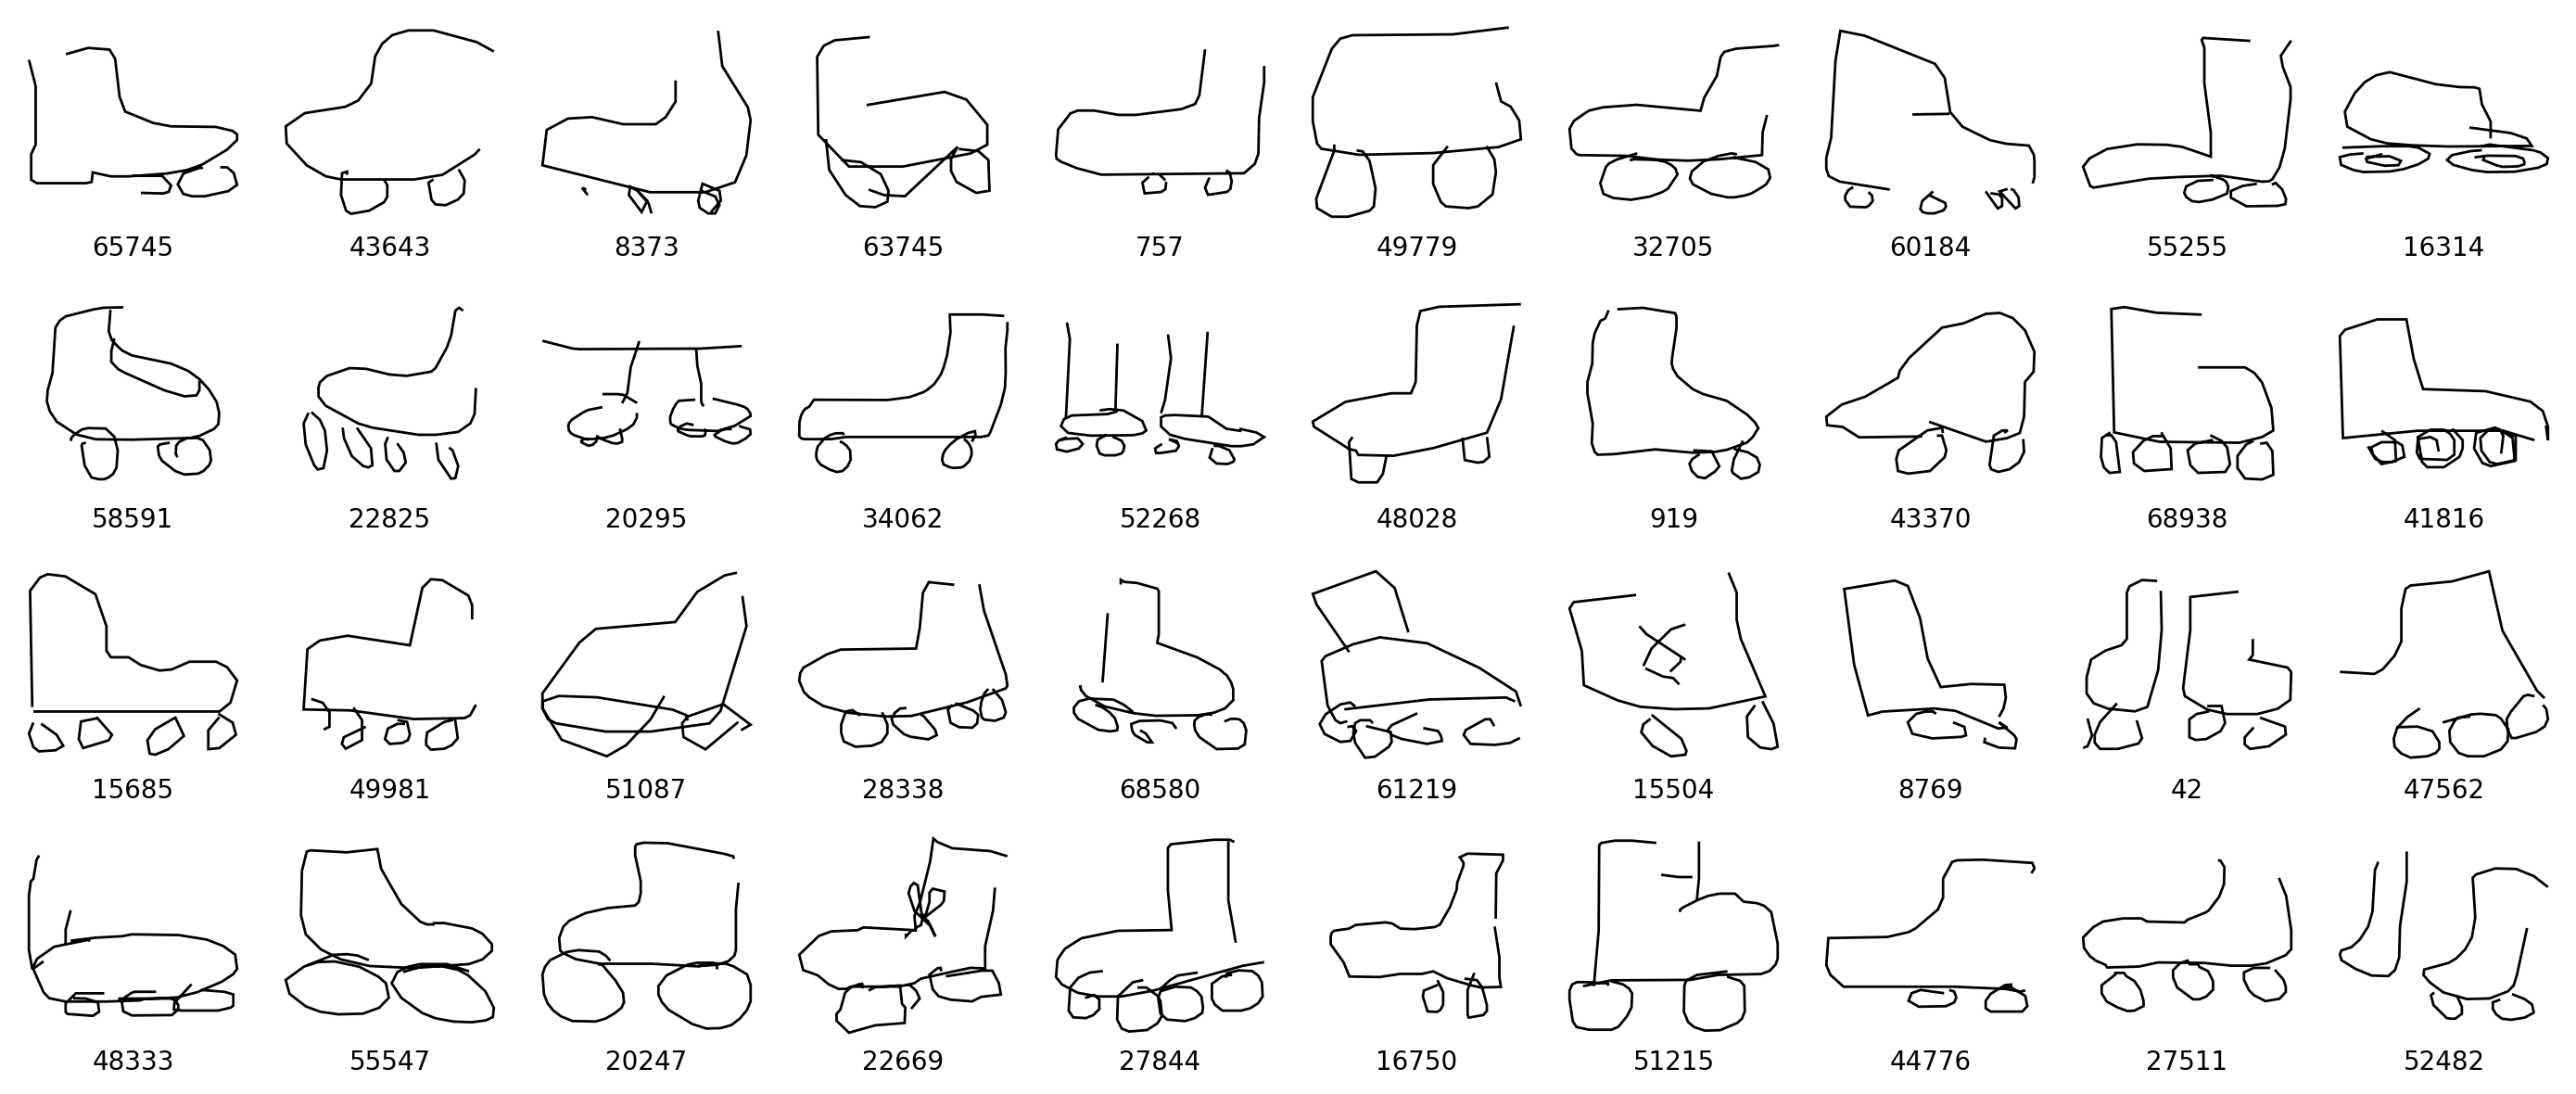

In [11]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(14, 6))

perm = np.random.permutation(range(len(data_train)))[:n[0]*n[1]]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
    utils.plot_strokes(ax[x][y], data_train[idx])
    ax[x][y].set(xlabel=idx)

utils.plt_show()

## Models

In [ ]:
hps = {
    "max_seq_len": max(map(len, np.concatenate([data['train'], data['valid'], data['test']]))),
    'batch_size': 100,
    "num_batches": math.ceil(len(data_train) / 100),
    "epochs": 100,
    "recurrent_dropout_prob": 0.1, ## 0.0 for gpu lstm
    "enc_rnn_size": 256,
    "dec_rnn_size": 512,
    "z_size": 128,
    "num_mixture": 20,
    "learning_rate": 0.001,
    "min_learning_rate": 0.00001,
    "decay_rate": 0.9999,
    "grad_clip": 1.0,
    'kl_tolerance': 0.2,
    'kl_decay_rate': 0.99995,
    "kl_weight": 0.5,
    'kl_weight_start': 0.01,
}

In [ ]:
sketchrnn = models.SketchRNN(hps)
sketchrnn.models['full'].summary()

Model: "sketchrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 131, 5)]     0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 128), (None, 667904      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
initial_state (Model)           [(None, 512), (None, 132096      encoder[1][0]                    
__________________________________________________________________________________________

## Training

In [ ]:
scale_factor = dataset.calc_scale_factor(data_train)

train_dataset = dataset.make_train_dataset(data_train, hps['max_seq_len'], hps['batch_size'], scale_factor)
val_dataset = dataset.make_val_dataset(data_valid, hps['max_seq_len'], hps['batch_size'], scale_factor)

In [ ]:
checkpoint_dir = '/content/gdrive/My Drive/sketchrnn/checkpoints'
log_dir = '/content/gdrive/My Drive/sketchrnn/logs'

!mkdir -p "{log_dir}" "{checkpoint_dir}"

initial_epoch = 90 #@param {type: "number"}
initial_loss = 0.05 #@param {type: "number"}
checkpoint = os.path.join(checkpoint_dir, 'sketch_rnn_' + data_class + '_weights.{:02d}_{:.2f}.hdf5')

if initial_epoch > 0:
    sketchrnn.load_weights(checkpoint.format(initial_epoch, initial_loss))

Loaded Weights From: /content/gdrive/My Drive/sketchrnn/checkpoints/sketch_rnn_rabbit_weights.90_0.05.hdf5


In [ ]:
sketchrnn.train(initial_epoch, train_dataset, val_dataset, checkpoint)

[train] epoch: 91/100, batch: 100, recon: 0.0715, kl: 0.3571, cost: 0.2425, lr: 0.000012, klw: 0.4791, time: 74.57
[train] epoch: 91/100, batch: 200, recon: 0.0644, kl: 0.3569, cost: 0.2354, lr: 0.000012, klw: 0.4792, time: 68.44
[train] epoch: 91/100, batch: 300, recon: 0.0132, kl: 0.3523, cost: 0.1821, lr: 0.000012, klw: 0.4793, time: 68.22
[train] epoch: 91/100, batch: 400, recon: 0.0197, kl: 0.3519, cost: 0.1884, lr: 0.000012, klw: 0.4794, time: 68.24
[train] epoch: 91/100, batch: 500, recon: -0.0061, kl: 0.3573, cost: 0.1652, lr: 0.000012, klw: 0.4795, time: 68.38
[train] epoch: 91/100, batch: 600, recon: 0.0171, kl: 0.3558, cost: 0.1878, lr: 0.000012, klw: 0.4796, time: 68.15
[train] epoch: 91/100, batch: 700, recon: 0.0351, kl: 0.3535, cost: 0.2047, lr: 0.000012, klw: 0.4797, time: 68.37
[validate] epoch: 91/100, recon: -0.1221, kl: 0.3595, cost: 0.0504
[train] epoch: 92/100, batch: 100, recon: 0.0606, kl: 0.3547, cost: 0.2308, lr: 0.000012, klw: 0.4798, time: 68.38
[train] epoc